<a href="https://colab.research.google.com/github/YakshRathod/NULLCLASS-Internship/blob/main/TASK_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
from PIL import Image, ImageDraw, ImageFont

# Set up dataset folder
output_dir = "/content/drive/MyDrive/Nullclass internship/Dataset for gan training"
os.makedirs(output_dir, exist_ok=True)

# Define objects and colors
objects = ["lamp", "chair", "table", "plant", "book", "cup", "clock"]
colors = ["red", "blue", "green", "yellow", "orange", "purple", "brown"]

# Generate dataset
num_images_per_object = 30  # total ~210 images
image_size = (128, 128)

for obj in objects:
    obj_dir = os.path.join(output_dir, obj)
    os.makedirs(obj_dir, exist_ok=True)

    for i in range(num_images_per_object):
        # Create a blank background
        bg_color = random.choice(colors)
        img = Image.new("RGB", image_size, color=bg_color)
        draw = ImageDraw.Draw(img)

        # Add a simple shape to simulate object
        shape_color = random.choice([c for c in colors if c != bg_color])
        shape_type = random.choice(["rectangle", "ellipse", "triangle"])
        x0, y0 = random.randint(10, 40), random.randint(10, 40)
        x1, y1 = random.randint(60, 120), random.randint(60, 120)

        if shape_type == "rectangle":
            draw.rectangle([x0, y0, x1, y1], fill=shape_color)
        elif shape_type == "ellipse":
            draw.ellipse([x0, y0, x1, y1], fill=shape_color)
        elif shape_type == "triangle":
            draw.polygon([ (x0, y1), ((x0+x1)//2, y0), (x1, y1) ], fill=shape_color)

        # Save image
        filename = f"{obj}_{i}.png"
        img.save(os.path.join(obj_dir, filename))

        # Save corresponding text description
        with open(os.path.join(obj_dir, f"{obj}_{i}.txt"), "w") as f:
            description = f"A {shape_color} {shape_type} representing a {obj} on a {bg_color} background"
            f.write(description)

print("Dataset generation complete!")


Dataset generation complete!


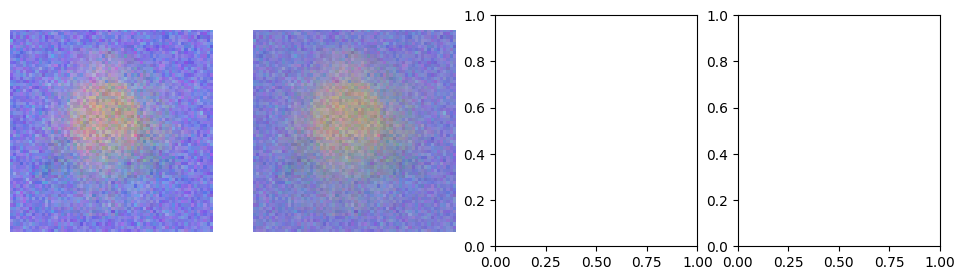

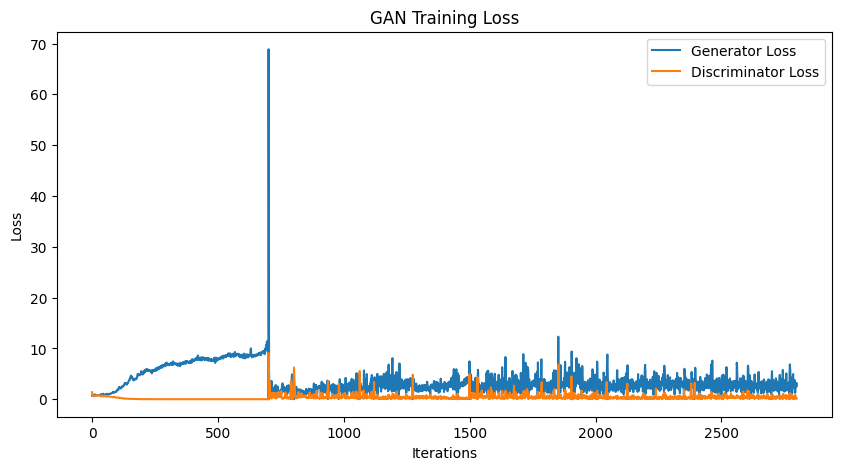

Training complete!


In [ ]:
# ==========================================
# IMPORTS
# ==========================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# ==========================================
# SIMPLE TOKENIZER
# ==========================================
class SimpleTokenizer:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}

    def build_vocab(self, captions):
        words = set()
        for cap in captions:
            words.update(cap.lower().split())
        self.word2idx = {word: idx+1 for idx, word in enumerate(sorted(words))}
        self.word2idx['<PAD>'] = 0
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, text, max_len=10):
        tokens = [self.word2idx.get(w,0) for w in text.lower().split()]
        if len(tokens) < max_len:
            tokens += [0]*(max_len-len(tokens))
        return tokens[:max_len]

# ==========================================
# DATASET CLASS (handles subfolders)
# ==========================================
class TextImageDataset(Dataset):
    def __init__(self, dataset_path, tokenizer, image_size=(64,64)):
        self.dataset_path = dataset_path
        self.tokenizer = tokenizer
        self.image_files = []
        self.captions = []

        # Traverse subfolders
        for root, _, files in os.walk(dataset_path):
            for f in files:
                if f.endswith(".png"):
                    txt_file = os.path.join(root, f.replace(".png",".txt"))
                    if os.path.exists(txt_file):
                        self.image_files.append(os.path.join(root,f))
                        self.captions.append(txt_file)

        if len(self.image_files) == 0:
            raise ValueError(f"No images with corresponding .txt files found in {dataset_path}")

        self.image_size = image_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB").resize(self.image_size)
        img_tensor = torch.tensor(np.array(img)/255., dtype=torch.float32).permute(2,0,1)

        # Load caption
        cap_file = self.captions[idx]
        with open(cap_file,"r") as f:
            caption = f.read().strip()
        tokens = torch.tensor(self.tokenizer.encode(caption), dtype=torch.long)
        return img_tensor, tokens

# ==========================================
# GENERATOR
# ==========================================
class Generator(nn.Module):
    def __init__(self, z_dim=100, embed_dim=10, img_channels=3, img_size=64):
        super().__init__()
        self.embed = nn.Embedding(1000, embed_dim)
        self.model = nn.Sequential(
            nn.Linear(z_dim+embed_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, img_channels*img_size*img_size),
            nn.Tanh()
        )
        self.img_channels = img_channels
        self.img_size = img_size

    def forward(self, z, captions):
        cap_embed = self.embed(captions).mean(dim=1)
        if z.size(0) != cap_embed.size(0):
            min_batch = min(z.size(0), cap_embed.size(0))
            z = z[:min_batch]
            cap_embed = cap_embed[:min_batch]
        x = torch.cat([z, cap_embed], dim=1)
        img = self.model(x).view(-1, self.img_channels, self.img_size, self.img_size)
        return img

# ==========================================
# DISCRIMINATOR
# ==========================================
class Discriminator(nn.Module):
    def __init__(self, embed_dim=10, img_channels=3, img_size=64):
        super().__init__()
        self.embed = nn.Embedding(1000, embed_dim)
        self.model = nn.Sequential(
            nn.Linear(img_channels*img_size*img_size + embed_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,1)
        )

    def forward(self, img, captions):
        cap_embed = self.embed(captions).mean(dim=1)
        img_flat = img.view(img.size(0), -1)
        if img_flat.size(0) != cap_embed.size(0):
            min_batch = min(img_flat.size(0), cap_embed.size(0))
            img_flat = img_flat[:min_batch]
            cap_embed = cap_embed[:min_batch]
        x = torch.cat([img_flat, cap_embed], dim=1)
        return self.model(x)

# ==========================================
# TRAINING FUNCTION
# ==========================================
def train_gan_with_visuals(dataset_path, save_path, epochs=5, batch_size=16, lr=0.0002, device="cuda", sample_interval=100):
    # Prepare tokenizer
    all_captions = []
    for root, _, files in os.walk(dataset_path):
        for f in files:
            if f.endswith(".txt"):
                with open(os.path.join(root,f),"r") as file:
                    all_captions.append(file.read().strip())
    tokenizer = SimpleTokenizer()
    tokenizer.build_vocab(all_captions)

    dataset = TextImageDataset(dataset_path, tokenizer)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Models
    G = Generator().to(device)
    D = Discriminator().to(device)

    # Optimizers
    opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

    criterion = nn.BCEWithLogitsLoss()

    # Track losses
    G_losses = []
    D_losses = []

    # Ensure save_path exists
    os.makedirs(save_path, exist_ok=True)

    iteration = 0
    for epoch in range(epochs):
        for i, (real_imgs, captions) in enumerate(loader):
            real_imgs = real_imgs.to(device)
            captions = captions.to(device)
            batch_size_curr = real_imgs.size(0)

            valid = torch.ones(batch_size_curr,1, device=device)
            fake = torch.zeros(batch_size_curr,1, device=device)

            # Train Discriminator
            z = torch.randn(batch_size_curr,100, device=device)
            fake_imgs = G(z, captions)
            D_real = D(real_imgs, captions)
            D_fake = D(fake_imgs.detach(), captions)
            loss_D = criterion(D_real, valid) + criterion(D_fake, fake)
            opt_D.zero_grad()
            loss_D.backward()
            opt_D.step()

            # Train Generator
            D_fake = D(fake_imgs, captions)
            loss_G = criterion(D_fake, valid)
            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()

            # Save losses
            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())

            iteration += 1
            if iteration % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] Batch {i}/{len(loader)} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

            # Show and save samples
            if iteration % sample_interval == 0:
                G.eval()
                with torch.no_grad():
                    sample_z = torch.randn(4, 100, device=device)
                    sample_captions = captions[:4]
                    sample_imgs = G(sample_z, sample_captions).cpu()
                G.train()

                # Save images with caption in filename
                for idx, img in enumerate(sample_imgs):
                    caption_text = "_".join(sample_captions[idx].cpu().numpy().astype(str))
                    caption_text = caption_text[:50]  # truncate long captions
                    img_pil = Image.fromarray(((img.permute(1,2,0).numpy()*0.5+0.5)*255).astype(np.uint8))
                    save_filename = f"epoch{epoch+1}_iter{iteration}_img{idx}_{caption_text}.png"
                    save_filename = "".join(c for c in save_filename if c.isalnum() or c in "._")
                    img_pil.save(os.path.join(save_path, save_filename))

                clear_output(wait=True)
                fig, axs = plt.subplots(1, 4, figsize=(12,3))
                for idx, img in enumerate(sample_imgs):
                    axs[idx].imshow((img.permute(1,2,0)*0.5+0.5).clamp(0,1))
                    axs[idx].axis('off')
                plt.show()

    # Final Loss Plot
    plt.figure(figsize=(10,5))
    plt.plot(G_losses, label="Generator Loss")
    plt.plot(D_losses, label="Discriminator Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("GAN Training Loss")
    plt.legend()
    plt.show()

    print("Training complete!")
    return G, D, tokenizer

# ==========================================
# HOW TO RUN
# ==========================================
dataset_path = "/content/drive/MyDrive/Nullclass internship/Dataset for gan training"
save_path = "/content/drive/MyDrive/Nullclass internship/GAN_samples"
device = "cuda" if torch.cuda.is_available() else "cpu"
G_model, D_model, tokenizer = train_gan_with_visuals(dataset_path, save_path, epochs=200, batch_size=16, device=device)


In [ ]:
import glob
import os

dataset_path = "/content/drive/MyDrive/Nullclass internship/Dataset for gan training"
img_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.PNG', '*.JPEG']

image_files = []
for ext in img_extensions:
    image_files.extend(glob.glob(os.path.join(dataset_path, '**', ext), recursive=True))

print(f"Found {len(image_files)} images")


Found 210 images
